In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist
from matplotlib import cm
from sklearn.metrics import pairwise_distances_argmin_min
from collections import defaultdict

#def draw_custom_dendrogram(merge_history, labels):
#
#    n = len(labels)
#    current_idx = n
#    positions = {i: i for i in range(n)}
#    heights = {}
#
#    fig, ax = plt.subplots(figsize=(10, 5))
#
#    for c1, c2, dist, size in merge_history:
#        x1 = positions[c1]
#        x2 = positions[c2]
#        y = dist
#
#        ax.plot([x1, x1], [heights.get(c1, 0), y], c="black")
#        ax.plot([x2, x2], [heights.get(c2, 0), y], c="black")
#        ax.plot([x1, x2], [y, y], c="black")
#
#        positions[current_idx] = (x1 + x2) / 2
#        heights[current_idx] = y
#        current_idx += 1
#
#    ax.set_title("Custom Dendrogram")
#    ax.set_xlabel("Sample index (approx.)")
#    ax.set_ylabel("Distance")
#    plt.show()

def compute_fitness(individual):
    return np.sum(np.square(individual))

def draw_colored_dendrogram(merge_history, labels, num_points):
    fig, ax = plt.subplots(figsize=(12, 6))
    positions = {i: i for i in range(num_points)}  # x-ové pozice pro jednotlivé listy
    heights = {}  # y-ové výšky (vzdálenosti) pro spojení
    cluster_colors = cm.tab10.colors  # 10 předdefinovaných barev (opakují se)
    color_map = {}  # cluster_id -> barva

    current_idx = num_points  # virtuální indexy pro spojení (větve)

    # Barva každého původního bodu podle jeho finálního clusteru
    for i, cluster_id in enumerate(labels):
        color_map[i] = cluster_colors[cluster_id % len(cluster_colors)]

    # Kreslení jednotlivých spojení (větví)
    for idx1, idx2, dist, size in merge_history:
        x1 = positions[idx1]
        x2 = positions[idx2]
        y = dist

        # Barvy levé a pravé větve
        c1 = color_map.get(idx1, 'black')
        c2 = color_map.get(idx2, 'black')
        merged_color = c1 if c1 == c2 else 'gray'

        # Svislé čáry
        ax.plot([x1, x1], [heights.get(idx1, 0), y], c=c1, linewidth=2)
        ax.plot([x2, x2], [heights.get(idx2, 0), y], c=c2, linewidth=2)

        # Vodorovná čára spojení
        ax.plot([x1, x2], [y, y], c=merged_color, linewidth=2)

        # Nový uzel pro další slučování
        positions[current_idx] = (x1 + x2) / 2
        heights[current_idx] = y
        color_map[current_idx] = merged_color

        current_idx += 1

    ax.set_title("Barevný dendrogram (vlastní kreslení)")
    ax.set_xlabel("Index vzorku")
    ax.set_ylabel("Vzdálenost")
    ax.grid(True)
    plt.tight_layout()
    plt.show()

def hierarchical_clustering(data, num_clusters=None, min_distance=None):
    clusters = {i: [i] for i in range(len(data))}
    centroids = {i: data[i] for i in range(len(data))}
    merge_history = []
    cluster_sizes = {i: 1 for i in range(len(data))}

    while True:
        min_dist = float("inf")
        to_merge = None
        
        cluster_keys = list(clusters.keys())
        for i in range(len(cluster_keys)):
            for j in range(i + 1, len(cluster_keys)):
                c1, c2 = cluster_keys[i], cluster_keys[j]
                dist = np.linalg.norm(centroids[c1] - centroids[c2])
                if dist < min_dist:
                    min_dist = dist
                    to_merge = (c1, c2)

        if to_merge is None:
            break

        if min_distance is not None and min_dist > min_distance:
            break

        if num_clusters is not None and len(clusters) <= num_clusters:
            break

        c1, c2 = to_merge
        new_cluster = clusters[c1] + clusters[c2]
        new_centroid = np.mean([data[i] for i in new_cluster], axis=0)

        # Aktualizace clusterů
        new_key = max(clusters.keys()) + 1
        clusters[new_key] = new_cluster
        centroids[new_key] = new_centroid

        merge_history.append((c1, c2, min_dist, len(new_cluster)))
        cluster_sizes[max(clusters.keys()) + 1] = len(new_cluster)

        del clusters[c1]
        del clusters[c2]
        del centroids[c1]
        del centroids[c2]

    labels = np.zeros(len(data), dtype=int)
    for cluster_idx, cluster_points in enumerate(clusters.values()):
        for point in cluster_points:
            labels[point] = cluster_idx

    return labels, merge_history

def run(dataset, num_clusters, step):
    df = pd.read_csv(dataset)
    id_cluster_map = defaultdict(list)
    cluster_counts = []
    cluster_size_history = []
    centroid_history = []
    wcss_history = []


    unique_generations = sorted(df["generation"].unique())

    selected_generations = [unique_generations[0]] + unique_generations[step-1::step] + [unique_generations[-1]]

    first_gen_data = df[df["generation"] == unique_generations[0]].drop(columns=["generation", "id"]).values
    pca = PCA(n_components=2)
    pca.fit(first_gen_data)

    for gen in selected_generations:
        pop_data = df[df["generation"] == gen].drop(columns=["generation", "id"]).values
        reduced_data = pca.transform(pop_data)

        pairwise_distances = cdist(pop_data, pop_data)
        max_distance = np.max(pairwise_distances)
        min_dist_threshold = 0.40 * max_distance


        clusters, merge_history = hierarchical_clustering(pop_data, min_distance=min_dist_threshold)

        # Ulož počet clusterů
        cluster_counts.append(len(set(clusters)))

        # Ulož mapu ID → cluster
        ids = df[df["generation"] == gen]["id"].values
        for ident, cl in zip(ids, clusters):
            id_cluster_map[ident].append(cl)

        # Spočítej velikosti
        sizes = [np.sum(clusters == i) for i in sorted(set(clusters))]
        cluster_size_history.append(sizes)
        #print(f"\nGenerace {gen} - {len(sizes)} clusterů")
        #for i, size in enumerate(sizes):
        #    print(f"  Cluster {i}: {size} jedinců")


        # Spočítej centroidy
        centroids = []
        for i in sorted(set(clusters)):
            members = pop_data[clusters == i]
            if len(members) > 0:
                centroids.append(np.mean(members, axis=0))
        centroid_history.append(centroids)

        # Výpočet WCSS (inercie) pro hierarchické shlukování
        wcss = 0.0
        for i, centroid in enumerate(centroids):
            members = pop_data[clusters == i]
            if len(members) > 0:
                dists = np.linalg.norm(members - centroid, axis=1)
                wcss += np.sum(dists ** 2)
        wcss_history.append(wcss)



        plt.figure(figsize=(6, 6))
        #scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis', alpha=0.7)
        plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis', alpha=0.7)
        plt.title(f"Generation {gen} - Custom Hierarchical Clustering")
        plt.xlabel("PCA Component 1")
        plt.ylabel("PCA Component 2")
        plt.show()

        # === Histogram velikostí clusterů ===
        unique_labels = sorted(set(clusters))
        cluster_sizes = [np.sum(clusters == label) for label in unique_labels]
        plt.figure(figsize=(6, 4))
        plt.bar(unique_labels, cluster_sizes, color='skyblue', edgecolor='black')
        plt.xlabel("Index clusteru")
        plt.ylabel("Počet jedinců")
        plt.title(f"Histogram velikostí clusterů - generace {gen}")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # === Analýza stability clusterů mezi generacemi ===
        if len(id_cluster_map[next(iter(id_cluster_map))]) > 1:
            stability = {i: [] for i in range(num_clusters)}  # cluster_id → seznam počtů přeběhlíků

            for gen_idx in range(1, len(selected_generations)):
                current_gen = selected_generations[gen_idx]
                previous_gen = selected_generations[gen_idx - 1]

                cluster_transitions = defaultdict(lambda: defaultdict(int))  # prev_cluster -> current_cluster -> count

                for ident, history in id_cluster_map.items():
                    if len(history) > gen_idx:
                        prev_label = history[gen_idx - 1]
                        curr_label = history[gen_idx]
                        cluster_transitions[prev_label][curr_label] += 1

                print(f"\nStabilita mezi generací {previous_gen} → {current_gen}:")
                for prev_label, curr_counts in cluster_transitions.items():
                    total = sum(curr_counts.values())
                    for curr_label, count in curr_counts.items():
                        print(f"  Cluster {prev_label} → {curr_label}: {count} jedinců ({count/total*100:.1f} %)")

        # === Boxplot fitness hodnot v jednotlivých clusterech ===
        gen_data = df[df["generation"] == gen]
        pop_values = gen_data.drop(columns=["generation", "id"]).values
        fitness_values = np.array([compute_fitness(ind) for ind in pop_values])

        # Získání unikátních cluster ID (vynecháme -1 = noise)
        cluster_ids = sorted(set(clusters) - {-1})

        # Inicializace slovníku
        cluster_fitness = {cl: [] for cl in cluster_ids}

        # Naplnění fitness hodnot do jednotlivých clusterů
        for i, cl in enumerate(clusters):
            if cl in cluster_fitness:
                cluster_fitness[cl].append(fitness_values[i])

        # Vykreslení boxplotu
        plt.figure(figsize=(8, 5))
        plt.boxplot([cluster_fitness[cl] for cl in cluster_ids],
                    labels=[f"Cluster {cl}" for cl in cluster_ids])
        plt.xlabel("Cluster")
        plt.ylabel("Fitness")
        plt.title(f"Distribuce fitness hodnot – generace {gen}")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        

        #TODO: Nutno upravit a udělat custom jelikož to vůbec nesedí k vytvořeným clusterům
        #linkage_matrix = linkage(reduced_data, method='ward')
        #linkage_matrix = linkage(pop_data, method='ward')
        #plt.figure(figsize=(8, 5))
        #dendrogram(linkage_matrix, truncate_mode="level", p=5)  # Zkrácení na 5 úrovní pro lepší čitelnost
        #dendrogram(linkage_matrix, labels=df[df["generation"] == gen]["id"].values)
        #plt.title(f"Generation {gen} - Dendrogram")
        #plt.xlabel("Sample index")
        #plt.ylabel("Distance")
        #plt.show()

        switch_counts = {}
        for ident, history in id_cluster_map.items():
            switches = sum(1 for a, b in zip(history, history[1:]) if a != b)
            switch_counts[ident] = switches

        total = len(switch_counts)
        same = sum(1 for s in switch_counts.values() if s == 0)
        once = sum(1 for s in switch_counts.values() if s == 1)
        many = sum(1 for s in switch_counts.values() if s > 1)

        print("Statistiky pohybu mezi clustery:")
        print(f"Celkem jedinců: {total}")
        print(f"Zůstali ve stejném clusteru: {same} ({same/total*100:.1f} %)")
        print(f"Změnili cluster jednou: {once} ({once/total*100:.1f} %)")
        print(f"Změnili cluster vícekrát: {many} ({many/total*100:.1f} %)")


        #draw_colored_dendrogram(merge_history, clusters, num_points=len(pop_data))
    
    plt.figure(figsize=(8, 4))
    plt.plot(selected_generations, cluster_counts, marker='o')
    plt.xlabel("Generace")
    plt.ylabel("Počet clusterů")
    plt.title("Vývoj počtu clusterů v čase")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    max_len = max(len(row) for row in cluster_size_history)
    cluster_array = np.zeros((len(cluster_size_history), max_len))
    for i, sizes in enumerate(cluster_size_history):
        for j, s in enumerate(sizes):
            cluster_array[i, j] = s

    plt.figure(figsize=(12, 5))
    for j in range(cluster_array.shape[1]):
        plt.plot(selected_generations, cluster_array[:, j], label=f"Cluster {j}")
    plt.xlabel("Generace")
    plt.ylabel("Počet jedinců")
    plt.title("Vývoj velikosti clusterů")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    # === Vývoj průměrné vzdálenosti mezi centroidy ===
    average_intercentroid_distances = []
    for centroids in centroid_history:
        if len(centroids) < 2:
            average_intercentroid_distances.append(0)
            continue
        dists = cdist(centroids, centroids)
        upper_triangle = dists[np.triu_indices_from(dists, k=1)]
        avg_dist = np.mean(upper_triangle)
        average_intercentroid_distances.append(avg_dist)

    plt.figure(figsize=(8, 4))
    plt.plot(selected_generations, average_intercentroid_distances, marker='o', color='purple')
    plt.xlabel("Generace")
    plt.ylabel("Průměrná vzdálenost mezi centroidy")
    plt.title("Vývoj vzdáleností mezi centroidy")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    
    for i in range(len(centroid_history) - 1):
        print(f"\nPosun centroidů mezi generací {selected_generations[i]} a {selected_generations[i+1]}:")
        for j in range(min(len(centroid_history[i]), len(centroid_history[i+1]))):
            dist = np.linalg.norm(centroid_history[i][j] - centroid_history[i+1][j])
            print(f" - Cluster {j}: {dist:.4f}")
    
    # === Vývoj WCSS ===
    plt.figure(figsize=(8, 4))
    plt.plot(selected_generations, wcss_history, marker='o')
    plt.xlabel("Generace")
    plt.ylabel("WCSS (inercie)")
    plt.title("Vývoj kvality clusterů (inercie) – Hierarchické")
    plt.grid(True)
    plt.tight_layout()
    plt.show()



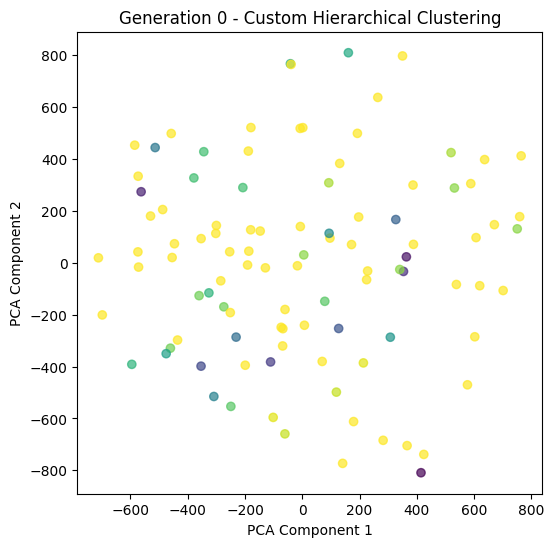

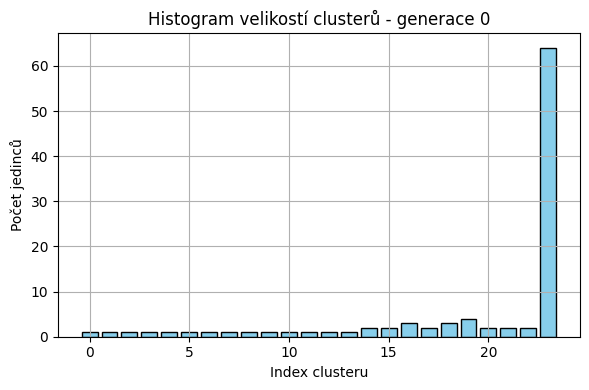

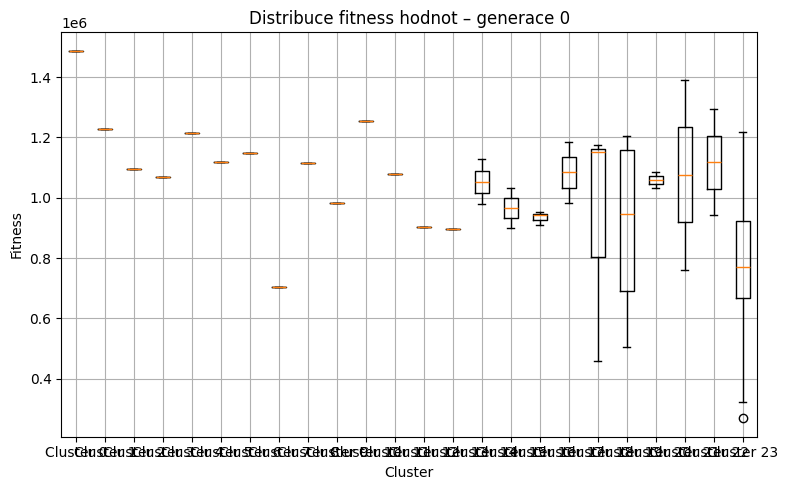

Statistiky pohybu mezi clustery:
Celkem jedinců: 100
Zůstali ve stejném clusteru: 100 (100.0 %)
Změnili cluster jednou: 0 (0.0 %)
Změnili cluster vícekrát: 0 (0.0 %)


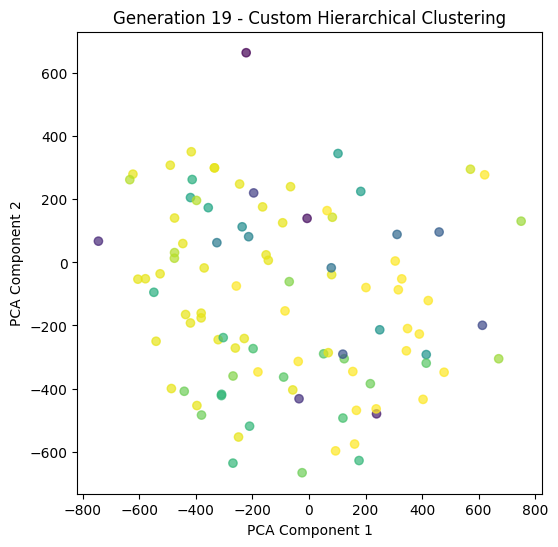

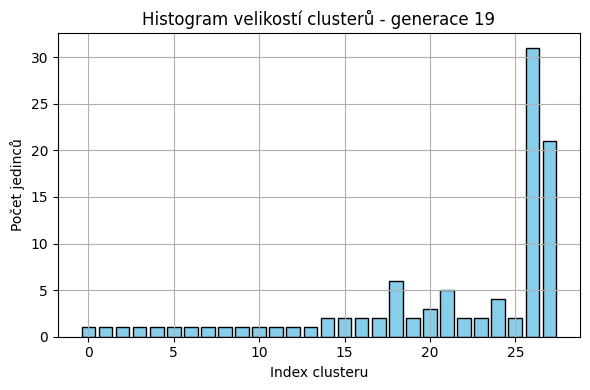


Stabilita mezi generací 0 → 19:
  Cluster 23 → 26: 19 jedinců (29.7 %)
  Cluster 23 → 27: 17 jedinců (26.6 %)
  Cluster 23 → 25: 2 jedinců (3.1 %)
  Cluster 23 → 18: 3 jedinců (4.7 %)
  Cluster 23 → 16: 1 jedinců (1.6 %)
  Cluster 23 → 17: 2 jedinců (3.1 %)
  Cluster 23 → 1: 1 jedinců (1.6 %)
  Cluster 23 → 2: 1 jedinců (1.6 %)
  Cluster 23 → 21: 3 jedinců (4.7 %)
  Cluster 23 → 3: 1 jedinců (1.6 %)
  Cluster 23 → 14: 2 jedinců (3.1 %)
  Cluster 23 → 4: 1 jedinců (1.6 %)
  Cluster 23 → 24: 2 jedinců (3.1 %)
  Cluster 23 → 20: 2 jedinců (3.1 %)
  Cluster 23 → 23: 1 jedinců (1.6 %)
  Cluster 23 → 19: 1 jedinců (1.6 %)
  Cluster 23 → 6: 1 jedinců (1.6 %)
  Cluster 23 → 22: 1 jedinců (1.6 %)
  Cluster 23 → 7: 1 jedinců (1.6 %)
  Cluster 23 → 8: 1 jedinců (1.6 %)
  Cluster 23 → 15: 1 jedinců (1.6 %)
  Cluster 0 → 26: 1 jedinců (100.0 %)
  Cluster 1 → 16: 1 jedinců (100.0 %)
  Cluster 16 → 15: 1 jedinců (33.3 %)
  Cluster 16 → 20: 1 jedinců (33.3 %)
  Cluster 16 → 27: 1 jedinců (33.3 %)
  C

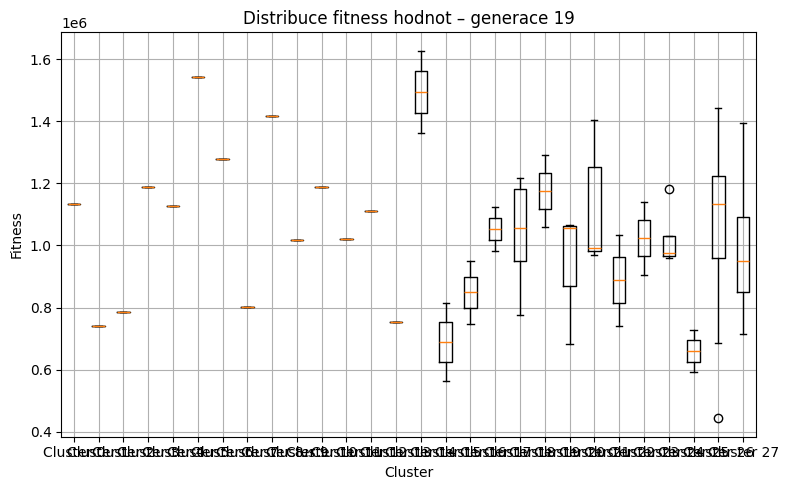

Statistiky pohybu mezi clustery:
Celkem jedinců: 100
Zůstali ve stejném clusteru: 4 (4.0 %)
Změnili cluster jednou: 96 (96.0 %)
Změnili cluster vícekrát: 0 (0.0 %)


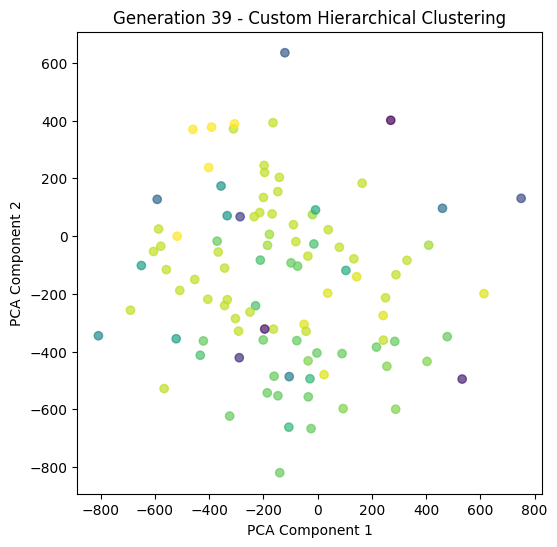

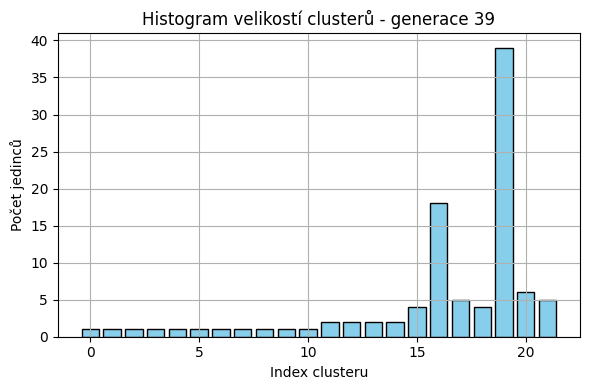


Stabilita mezi generací 0 → 19:
  Cluster 23 → 26: 19 jedinců (29.7 %)
  Cluster 23 → 27: 17 jedinců (26.6 %)
  Cluster 23 → 25: 2 jedinců (3.1 %)
  Cluster 23 → 18: 3 jedinců (4.7 %)
  Cluster 23 → 16: 1 jedinců (1.6 %)
  Cluster 23 → 17: 2 jedinců (3.1 %)
  Cluster 23 → 1: 1 jedinců (1.6 %)
  Cluster 23 → 2: 1 jedinců (1.6 %)
  Cluster 23 → 21: 3 jedinců (4.7 %)
  Cluster 23 → 3: 1 jedinců (1.6 %)
  Cluster 23 → 14: 2 jedinců (3.1 %)
  Cluster 23 → 4: 1 jedinců (1.6 %)
  Cluster 23 → 24: 2 jedinců (3.1 %)
  Cluster 23 → 20: 2 jedinců (3.1 %)
  Cluster 23 → 23: 1 jedinců (1.6 %)
  Cluster 23 → 19: 1 jedinců (1.6 %)
  Cluster 23 → 6: 1 jedinců (1.6 %)
  Cluster 23 → 22: 1 jedinců (1.6 %)
  Cluster 23 → 7: 1 jedinců (1.6 %)
  Cluster 23 → 8: 1 jedinců (1.6 %)
  Cluster 23 → 15: 1 jedinců (1.6 %)
  Cluster 0 → 26: 1 jedinců (100.0 %)
  Cluster 1 → 16: 1 jedinců (100.0 %)
  Cluster 16 → 15: 1 jedinců (33.3 %)
  Cluster 16 → 20: 1 jedinců (33.3 %)
  Cluster 16 → 27: 1 jedinců (33.3 %)
  C

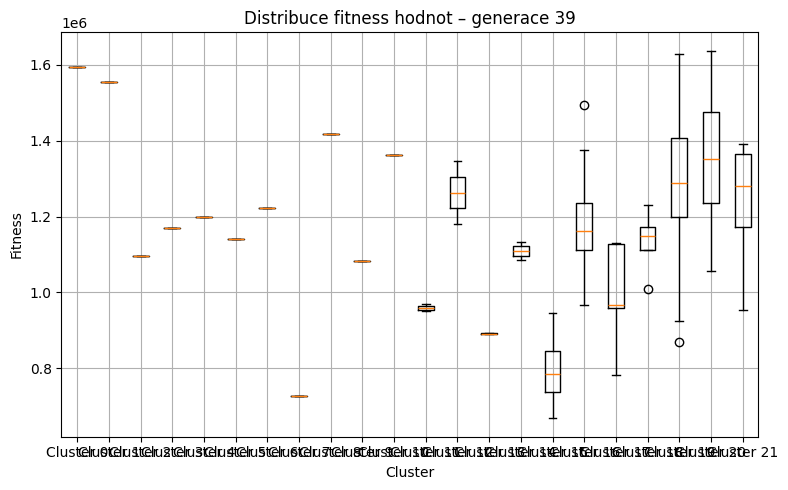

Statistiky pohybu mezi clustery:
Celkem jedinců: 100
Zůstali ve stejném clusteru: 1 (1.0 %)
Změnili cluster jednou: 7 (7.0 %)
Změnili cluster vícekrát: 92 (92.0 %)


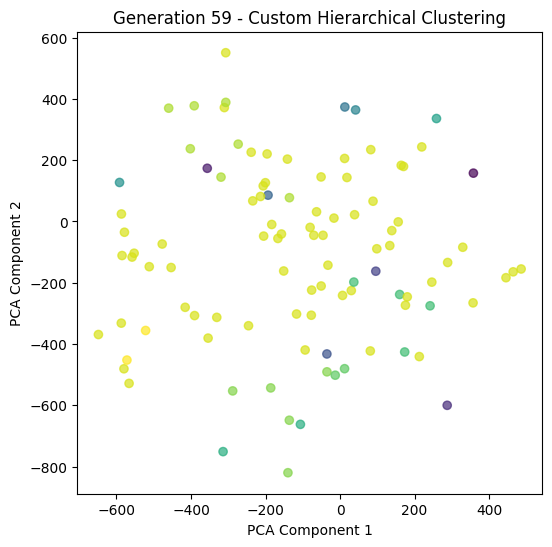

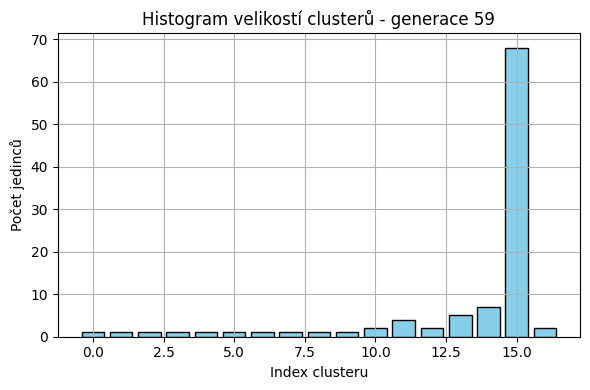


Stabilita mezi generací 0 → 19:
  Cluster 23 → 26: 19 jedinců (29.7 %)
  Cluster 23 → 27: 17 jedinců (26.6 %)
  Cluster 23 → 25: 2 jedinců (3.1 %)
  Cluster 23 → 18: 3 jedinců (4.7 %)
  Cluster 23 → 16: 1 jedinců (1.6 %)
  Cluster 23 → 17: 2 jedinců (3.1 %)
  Cluster 23 → 1: 1 jedinců (1.6 %)
  Cluster 23 → 2: 1 jedinců (1.6 %)
  Cluster 23 → 21: 3 jedinců (4.7 %)
  Cluster 23 → 3: 1 jedinců (1.6 %)
  Cluster 23 → 14: 2 jedinců (3.1 %)
  Cluster 23 → 4: 1 jedinců (1.6 %)
  Cluster 23 → 24: 2 jedinců (3.1 %)
  Cluster 23 → 20: 2 jedinců (3.1 %)
  Cluster 23 → 23: 1 jedinců (1.6 %)
  Cluster 23 → 19: 1 jedinců (1.6 %)
  Cluster 23 → 6: 1 jedinců (1.6 %)
  Cluster 23 → 22: 1 jedinců (1.6 %)
  Cluster 23 → 7: 1 jedinců (1.6 %)
  Cluster 23 → 8: 1 jedinců (1.6 %)
  Cluster 23 → 15: 1 jedinců (1.6 %)
  Cluster 0 → 26: 1 jedinců (100.0 %)
  Cluster 1 → 16: 1 jedinců (100.0 %)
  Cluster 16 → 15: 1 jedinců (33.3 %)
  Cluster 16 → 20: 1 jedinců (33.3 %)
  Cluster 16 → 27: 1 jedinců (33.3 %)
  C

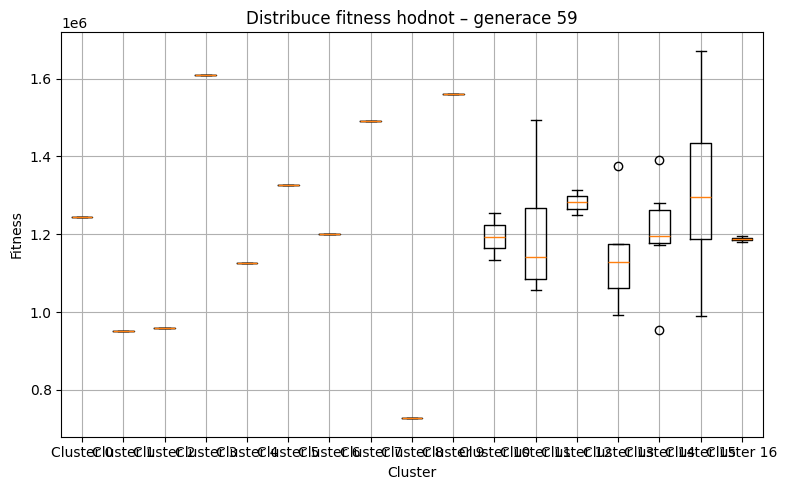

Statistiky pohybu mezi clustery:
Celkem jedinců: 100
Zůstali ve stejném clusteru: 0 (0.0 %)
Změnili cluster jednou: 1 (1.0 %)
Změnili cluster vícekrát: 99 (99.0 %)


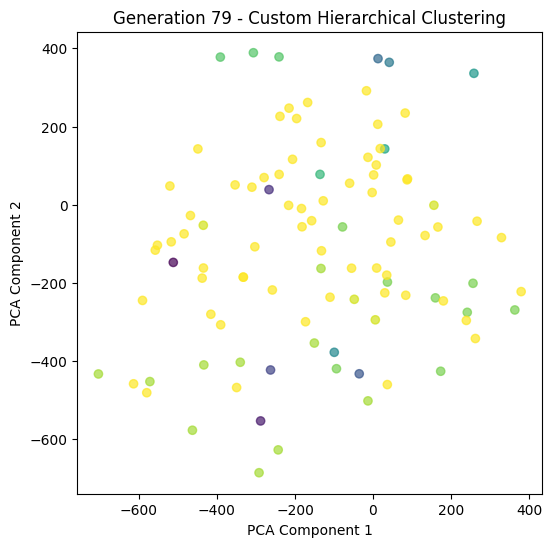

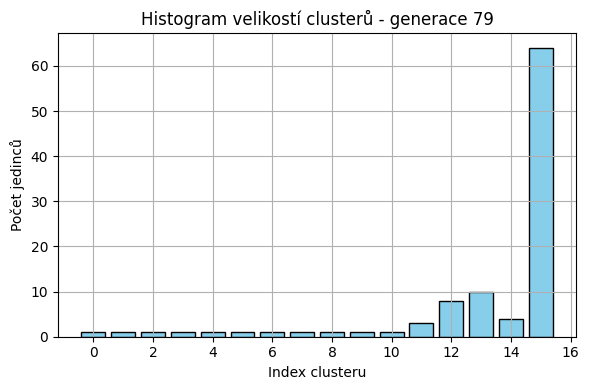


Stabilita mezi generací 0 → 19:
  Cluster 23 → 26: 19 jedinců (29.7 %)
  Cluster 23 → 27: 17 jedinců (26.6 %)
  Cluster 23 → 25: 2 jedinců (3.1 %)
  Cluster 23 → 18: 3 jedinců (4.7 %)
  Cluster 23 → 16: 1 jedinců (1.6 %)
  Cluster 23 → 17: 2 jedinců (3.1 %)
  Cluster 23 → 1: 1 jedinců (1.6 %)
  Cluster 23 → 2: 1 jedinců (1.6 %)
  Cluster 23 → 21: 3 jedinců (4.7 %)
  Cluster 23 → 3: 1 jedinců (1.6 %)
  Cluster 23 → 14: 2 jedinců (3.1 %)
  Cluster 23 → 4: 1 jedinců (1.6 %)
  Cluster 23 → 24: 2 jedinců (3.1 %)
  Cluster 23 → 20: 2 jedinců (3.1 %)
  Cluster 23 → 23: 1 jedinců (1.6 %)
  Cluster 23 → 19: 1 jedinců (1.6 %)
  Cluster 23 → 6: 1 jedinců (1.6 %)
  Cluster 23 → 22: 1 jedinců (1.6 %)
  Cluster 23 → 7: 1 jedinců (1.6 %)
  Cluster 23 → 8: 1 jedinců (1.6 %)
  Cluster 23 → 15: 1 jedinců (1.6 %)
  Cluster 0 → 26: 1 jedinců (100.0 %)
  Cluster 1 → 16: 1 jedinců (100.0 %)
  Cluster 16 → 15: 1 jedinců (33.3 %)
  Cluster 16 → 20: 1 jedinců (33.3 %)
  Cluster 16 → 27: 1 jedinců (33.3 %)
  C

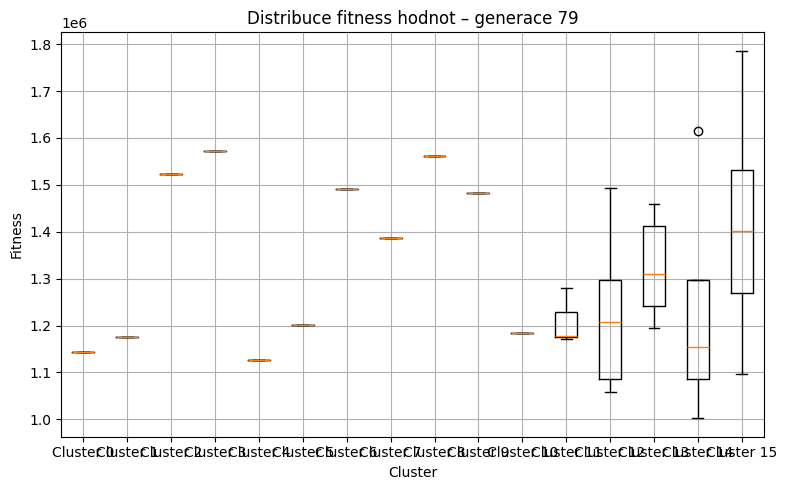

Statistiky pohybu mezi clustery:
Celkem jedinců: 100
Zůstali ve stejném clusteru: 0 (0.0 %)
Změnili cluster jednou: 1 (1.0 %)
Změnili cluster vícekrát: 99 (99.0 %)


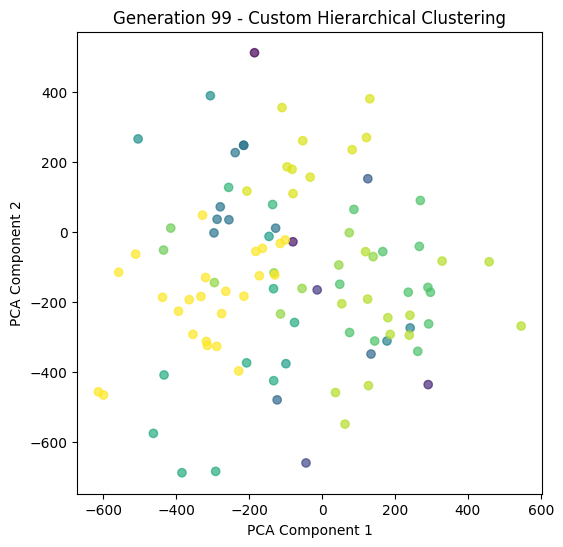

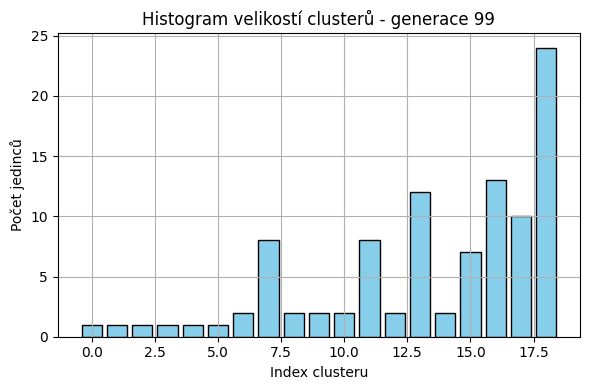


Stabilita mezi generací 0 → 19:
  Cluster 23 → 26: 19 jedinců (29.7 %)
  Cluster 23 → 27: 17 jedinců (26.6 %)
  Cluster 23 → 25: 2 jedinců (3.1 %)
  Cluster 23 → 18: 3 jedinců (4.7 %)
  Cluster 23 → 16: 1 jedinců (1.6 %)
  Cluster 23 → 17: 2 jedinců (3.1 %)
  Cluster 23 → 1: 1 jedinců (1.6 %)
  Cluster 23 → 2: 1 jedinců (1.6 %)
  Cluster 23 → 21: 3 jedinců (4.7 %)
  Cluster 23 → 3: 1 jedinců (1.6 %)
  Cluster 23 → 14: 2 jedinců (3.1 %)
  Cluster 23 → 4: 1 jedinců (1.6 %)
  Cluster 23 → 24: 2 jedinců (3.1 %)
  Cluster 23 → 20: 2 jedinců (3.1 %)
  Cluster 23 → 23: 1 jedinců (1.6 %)
  Cluster 23 → 19: 1 jedinců (1.6 %)
  Cluster 23 → 6: 1 jedinců (1.6 %)
  Cluster 23 → 22: 1 jedinců (1.6 %)
  Cluster 23 → 7: 1 jedinců (1.6 %)
  Cluster 23 → 8: 1 jedinců (1.6 %)
  Cluster 23 → 15: 1 jedinců (1.6 %)
  Cluster 0 → 26: 1 jedinců (100.0 %)
  Cluster 1 → 16: 1 jedinců (100.0 %)
  Cluster 16 → 15: 1 jedinců (33.3 %)
  Cluster 16 → 20: 1 jedinců (33.3 %)
  Cluster 16 → 27: 1 jedinců (33.3 %)
  C

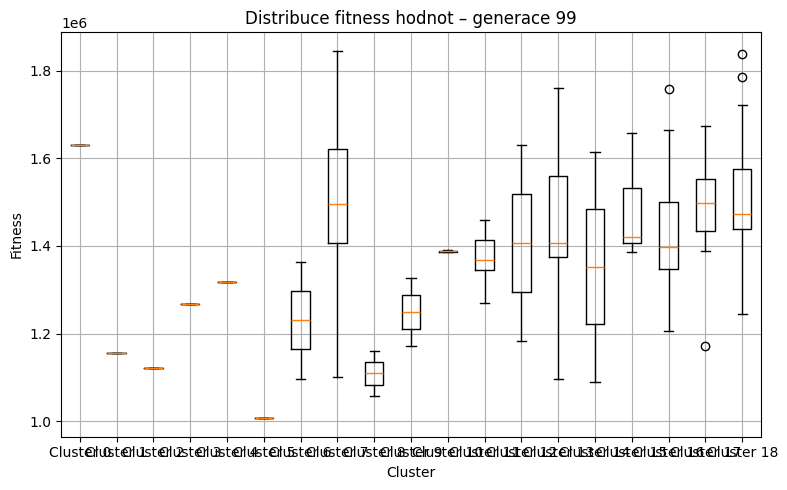

Statistiky pohybu mezi clustery:
Celkem jedinců: 100
Zůstali ve stejném clusteru: 0 (0.0 %)
Změnili cluster jednou: 0 (0.0 %)
Změnili cluster vícekrát: 100 (100.0 %)


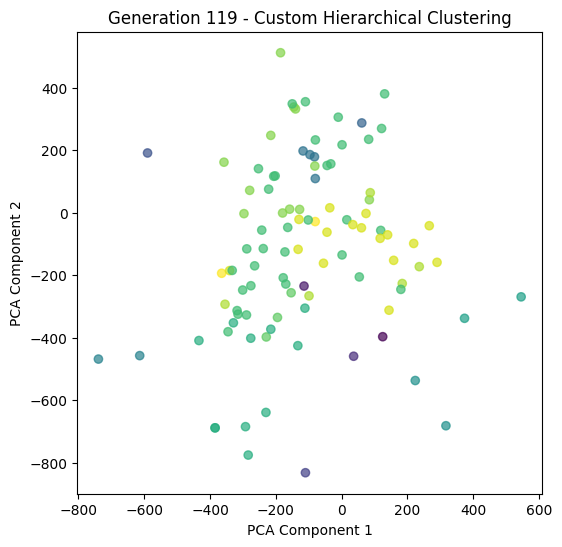

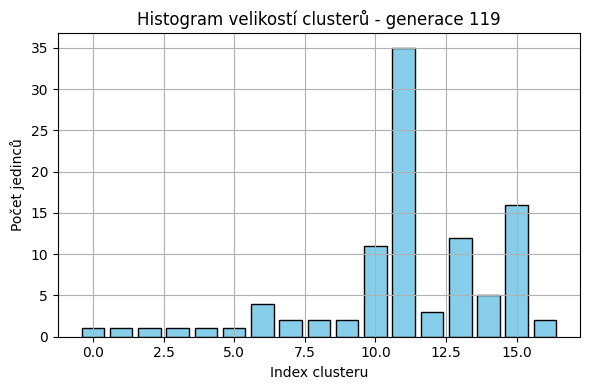


Stabilita mezi generací 0 → 19:
  Cluster 23 → 26: 19 jedinců (29.7 %)
  Cluster 23 → 27: 17 jedinců (26.6 %)
  Cluster 23 → 25: 2 jedinců (3.1 %)
  Cluster 23 → 18: 3 jedinců (4.7 %)
  Cluster 23 → 16: 1 jedinců (1.6 %)
  Cluster 23 → 17: 2 jedinců (3.1 %)
  Cluster 23 → 1: 1 jedinců (1.6 %)
  Cluster 23 → 2: 1 jedinců (1.6 %)
  Cluster 23 → 21: 3 jedinců (4.7 %)
  Cluster 23 → 3: 1 jedinců (1.6 %)
  Cluster 23 → 14: 2 jedinců (3.1 %)
  Cluster 23 → 4: 1 jedinců (1.6 %)
  Cluster 23 → 24: 2 jedinců (3.1 %)
  Cluster 23 → 20: 2 jedinců (3.1 %)
  Cluster 23 → 23: 1 jedinců (1.6 %)
  Cluster 23 → 19: 1 jedinců (1.6 %)
  Cluster 23 → 6: 1 jedinců (1.6 %)
  Cluster 23 → 22: 1 jedinců (1.6 %)
  Cluster 23 → 7: 1 jedinců (1.6 %)
  Cluster 23 → 8: 1 jedinců (1.6 %)
  Cluster 23 → 15: 1 jedinců (1.6 %)
  Cluster 0 → 26: 1 jedinců (100.0 %)
  Cluster 1 → 16: 1 jedinců (100.0 %)
  Cluster 16 → 15: 1 jedinců (33.3 %)
  Cluster 16 → 20: 1 jedinců (33.3 %)
  Cluster 16 → 27: 1 jedinců (33.3 %)
  C

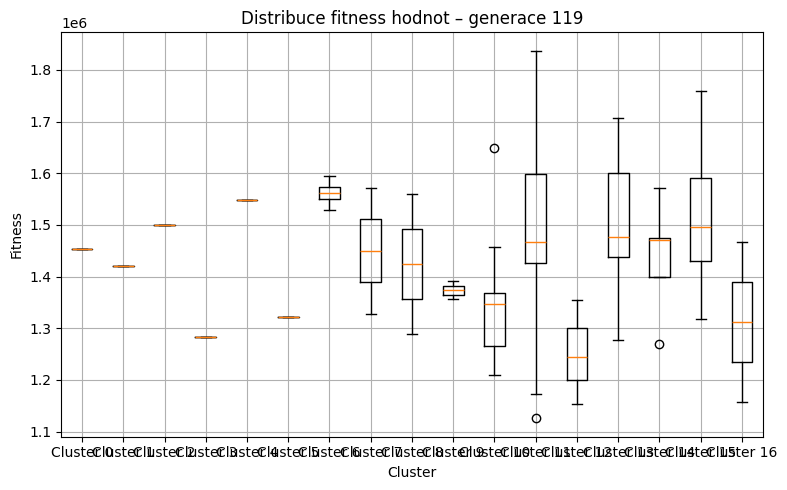

Statistiky pohybu mezi clustery:
Celkem jedinců: 100
Zůstali ve stejném clusteru: 0 (0.0 %)
Změnili cluster jednou: 0 (0.0 %)
Změnili cluster vícekrát: 100 (100.0 %)


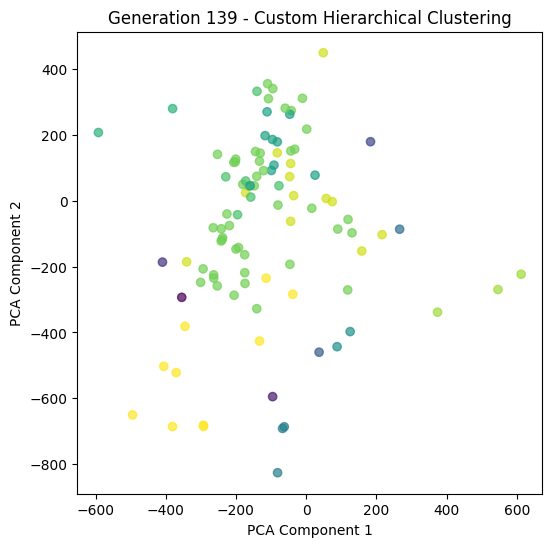

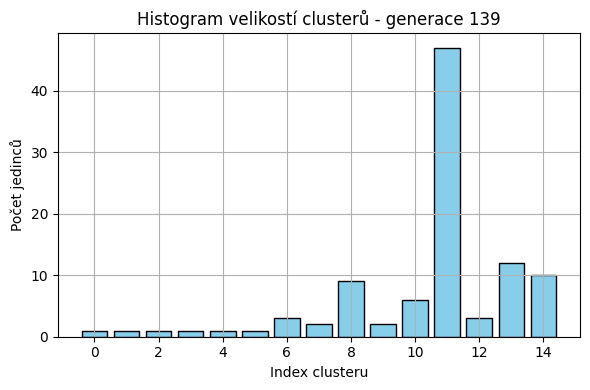


Stabilita mezi generací 0 → 19:
  Cluster 23 → 26: 19 jedinců (29.7 %)
  Cluster 23 → 27: 17 jedinců (26.6 %)
  Cluster 23 → 25: 2 jedinců (3.1 %)
  Cluster 23 → 18: 3 jedinců (4.7 %)
  Cluster 23 → 16: 1 jedinců (1.6 %)
  Cluster 23 → 17: 2 jedinců (3.1 %)
  Cluster 23 → 1: 1 jedinců (1.6 %)
  Cluster 23 → 2: 1 jedinců (1.6 %)
  Cluster 23 → 21: 3 jedinců (4.7 %)
  Cluster 23 → 3: 1 jedinců (1.6 %)
  Cluster 23 → 14: 2 jedinců (3.1 %)
  Cluster 23 → 4: 1 jedinců (1.6 %)
  Cluster 23 → 24: 2 jedinců (3.1 %)
  Cluster 23 → 20: 2 jedinců (3.1 %)
  Cluster 23 → 23: 1 jedinců (1.6 %)
  Cluster 23 → 19: 1 jedinců (1.6 %)
  Cluster 23 → 6: 1 jedinců (1.6 %)
  Cluster 23 → 22: 1 jedinců (1.6 %)
  Cluster 23 → 7: 1 jedinců (1.6 %)
  Cluster 23 → 8: 1 jedinců (1.6 %)
  Cluster 23 → 15: 1 jedinců (1.6 %)
  Cluster 0 → 26: 1 jedinců (100.0 %)
  Cluster 1 → 16: 1 jedinců (100.0 %)
  Cluster 16 → 15: 1 jedinců (33.3 %)
  Cluster 16 → 20: 1 jedinců (33.3 %)
  Cluster 16 → 27: 1 jedinců (33.3 %)
  C

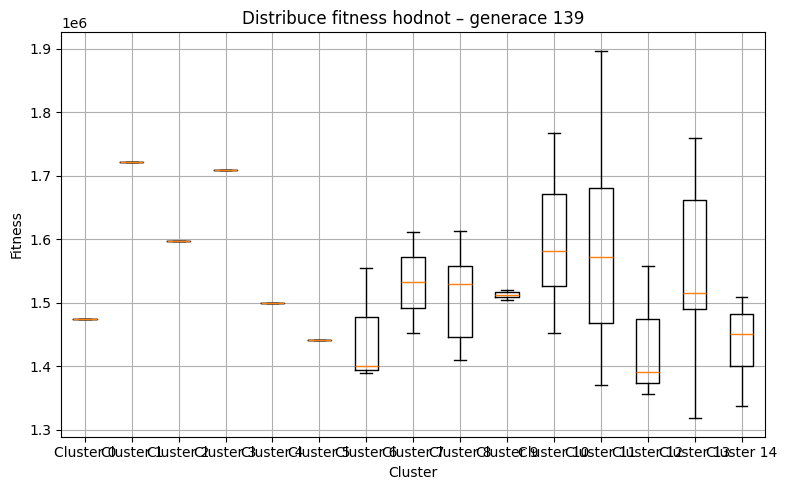

Statistiky pohybu mezi clustery:
Celkem jedinců: 100
Zůstali ve stejném clusteru: 0 (0.0 %)
Změnili cluster jednou: 0 (0.0 %)
Změnili cluster vícekrát: 100 (100.0 %)


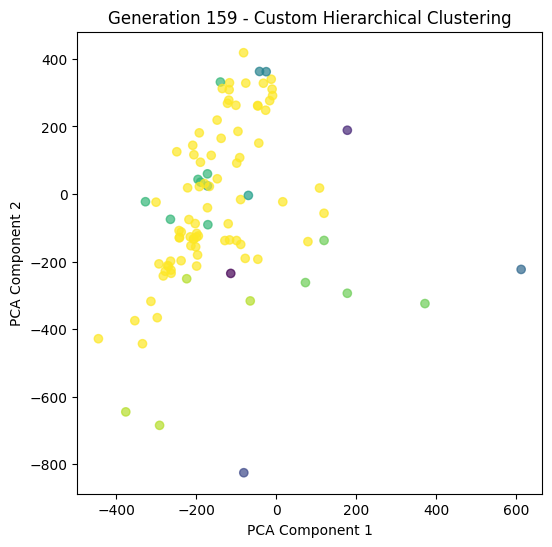

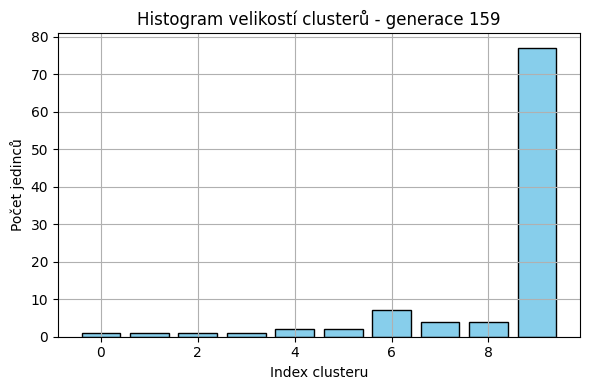


Stabilita mezi generací 0 → 19:
  Cluster 23 → 26: 19 jedinců (29.7 %)
  Cluster 23 → 27: 17 jedinců (26.6 %)
  Cluster 23 → 25: 2 jedinců (3.1 %)
  Cluster 23 → 18: 3 jedinců (4.7 %)
  Cluster 23 → 16: 1 jedinců (1.6 %)
  Cluster 23 → 17: 2 jedinců (3.1 %)
  Cluster 23 → 1: 1 jedinců (1.6 %)
  Cluster 23 → 2: 1 jedinců (1.6 %)
  Cluster 23 → 21: 3 jedinců (4.7 %)
  Cluster 23 → 3: 1 jedinců (1.6 %)
  Cluster 23 → 14: 2 jedinců (3.1 %)
  Cluster 23 → 4: 1 jedinců (1.6 %)
  Cluster 23 → 24: 2 jedinců (3.1 %)
  Cluster 23 → 20: 2 jedinců (3.1 %)
  Cluster 23 → 23: 1 jedinců (1.6 %)
  Cluster 23 → 19: 1 jedinců (1.6 %)
  Cluster 23 → 6: 1 jedinců (1.6 %)
  Cluster 23 → 22: 1 jedinců (1.6 %)
  Cluster 23 → 7: 1 jedinců (1.6 %)
  Cluster 23 → 8: 1 jedinců (1.6 %)
  Cluster 23 → 15: 1 jedinců (1.6 %)
  Cluster 0 → 26: 1 jedinců (100.0 %)
  Cluster 1 → 16: 1 jedinců (100.0 %)
  Cluster 16 → 15: 1 jedinců (33.3 %)
  Cluster 16 → 20: 1 jedinců (33.3 %)
  Cluster 16 → 27: 1 jedinců (33.3 %)
  C

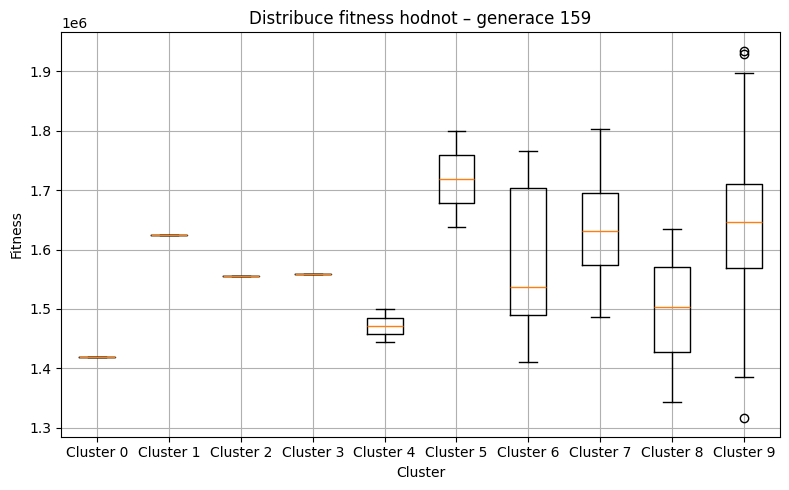

Statistiky pohybu mezi clustery:
Celkem jedinců: 100
Zůstali ve stejném clusteru: 0 (0.0 %)
Změnili cluster jednou: 0 (0.0 %)
Změnili cluster vícekrát: 100 (100.0 %)


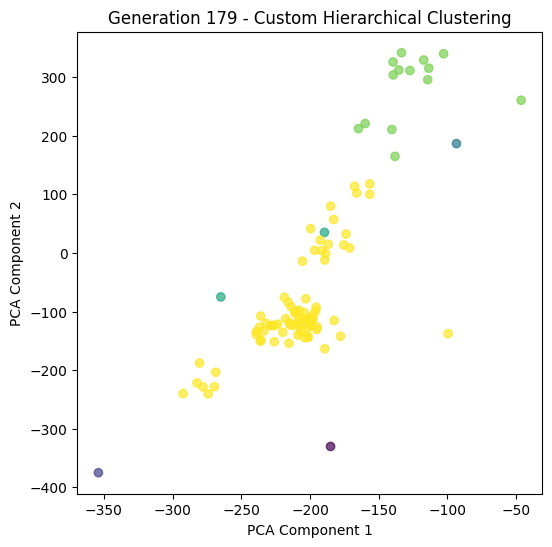

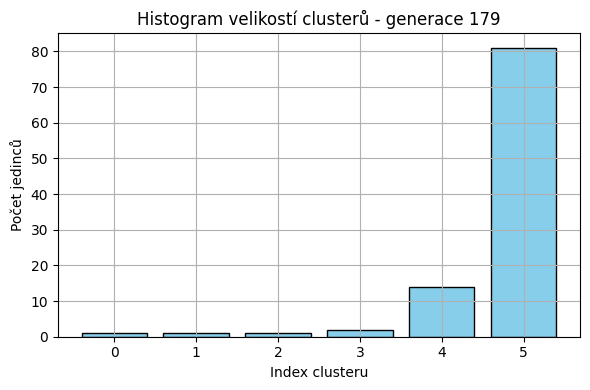


Stabilita mezi generací 0 → 19:
  Cluster 23 → 26: 19 jedinců (29.7 %)
  Cluster 23 → 27: 17 jedinců (26.6 %)
  Cluster 23 → 25: 2 jedinců (3.1 %)
  Cluster 23 → 18: 3 jedinců (4.7 %)
  Cluster 23 → 16: 1 jedinců (1.6 %)
  Cluster 23 → 17: 2 jedinců (3.1 %)
  Cluster 23 → 1: 1 jedinců (1.6 %)
  Cluster 23 → 2: 1 jedinců (1.6 %)
  Cluster 23 → 21: 3 jedinců (4.7 %)
  Cluster 23 → 3: 1 jedinců (1.6 %)
  Cluster 23 → 14: 2 jedinců (3.1 %)
  Cluster 23 → 4: 1 jedinců (1.6 %)
  Cluster 23 → 24: 2 jedinců (3.1 %)
  Cluster 23 → 20: 2 jedinců (3.1 %)
  Cluster 23 → 23: 1 jedinců (1.6 %)
  Cluster 23 → 19: 1 jedinců (1.6 %)
  Cluster 23 → 6: 1 jedinců (1.6 %)
  Cluster 23 → 22: 1 jedinců (1.6 %)
  Cluster 23 → 7: 1 jedinců (1.6 %)
  Cluster 23 → 8: 1 jedinců (1.6 %)
  Cluster 23 → 15: 1 jedinců (1.6 %)
  Cluster 0 → 26: 1 jedinců (100.0 %)
  Cluster 1 → 16: 1 jedinců (100.0 %)
  Cluster 16 → 15: 1 jedinců (33.3 %)
  Cluster 16 → 20: 1 jedinců (33.3 %)
  Cluster 16 → 27: 1 jedinců (33.3 %)
  C

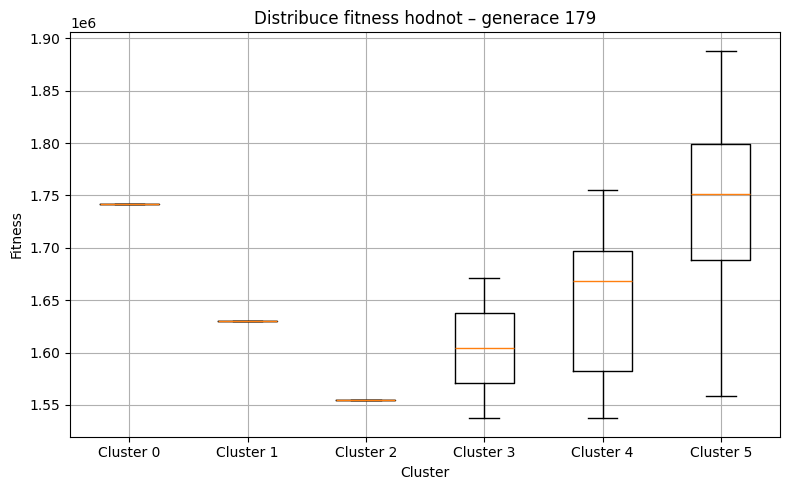

Statistiky pohybu mezi clustery:
Celkem jedinců: 100
Zůstali ve stejném clusteru: 0 (0.0 %)
Změnili cluster jednou: 0 (0.0 %)
Změnili cluster vícekrát: 100 (100.0 %)


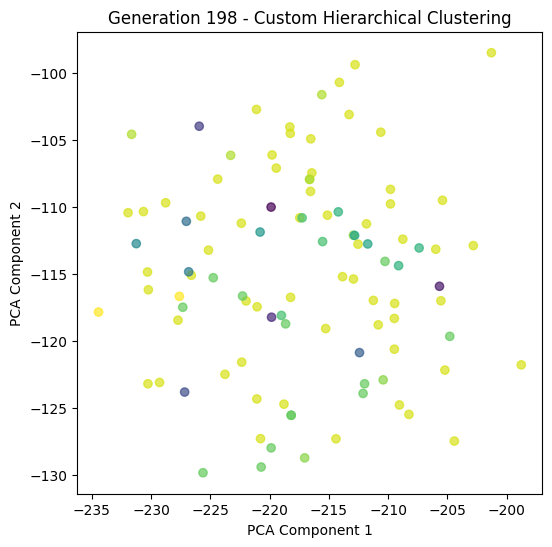

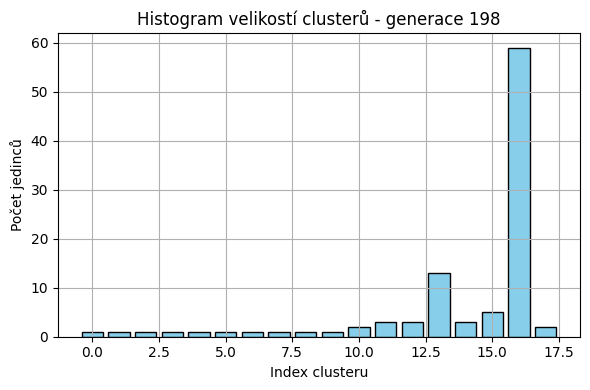


Stabilita mezi generací 0 → 19:
  Cluster 23 → 26: 19 jedinců (29.7 %)
  Cluster 23 → 27: 17 jedinců (26.6 %)
  Cluster 23 → 25: 2 jedinců (3.1 %)
  Cluster 23 → 18: 3 jedinců (4.7 %)
  Cluster 23 → 16: 1 jedinců (1.6 %)
  Cluster 23 → 17: 2 jedinců (3.1 %)
  Cluster 23 → 1: 1 jedinců (1.6 %)
  Cluster 23 → 2: 1 jedinců (1.6 %)
  Cluster 23 → 21: 3 jedinců (4.7 %)
  Cluster 23 → 3: 1 jedinců (1.6 %)
  Cluster 23 → 14: 2 jedinců (3.1 %)
  Cluster 23 → 4: 1 jedinců (1.6 %)
  Cluster 23 → 24: 2 jedinců (3.1 %)
  Cluster 23 → 20: 2 jedinců (3.1 %)
  Cluster 23 → 23: 1 jedinců (1.6 %)
  Cluster 23 → 19: 1 jedinců (1.6 %)
  Cluster 23 → 6: 1 jedinců (1.6 %)
  Cluster 23 → 22: 1 jedinců (1.6 %)
  Cluster 23 → 7: 1 jedinců (1.6 %)
  Cluster 23 → 8: 1 jedinců (1.6 %)
  Cluster 23 → 15: 1 jedinců (1.6 %)
  Cluster 0 → 26: 1 jedinců (100.0 %)
  Cluster 1 → 16: 1 jedinců (100.0 %)
  Cluster 16 → 15: 1 jedinců (33.3 %)
  Cluster 16 → 20: 1 jedinců (33.3 %)
  Cluster 16 → 27: 1 jedinců (33.3 %)
  C

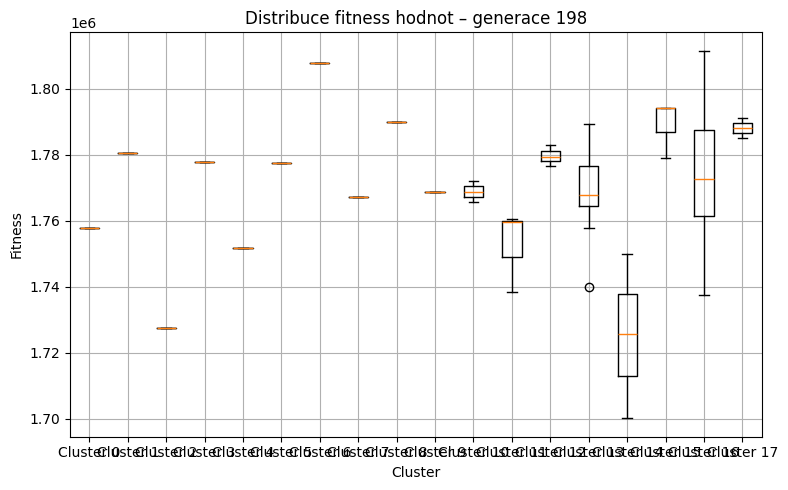

Statistiky pohybu mezi clustery:
Celkem jedinců: 100
Zůstali ve stejném clusteru: 0 (0.0 %)
Změnili cluster jednou: 0 (0.0 %)
Změnili cluster vícekrát: 100 (100.0 %)


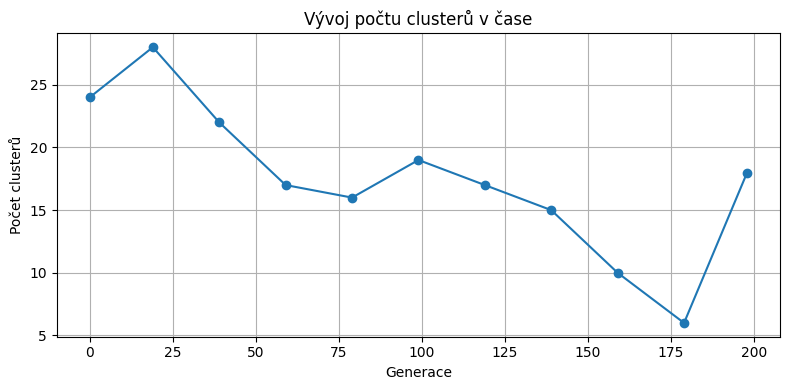

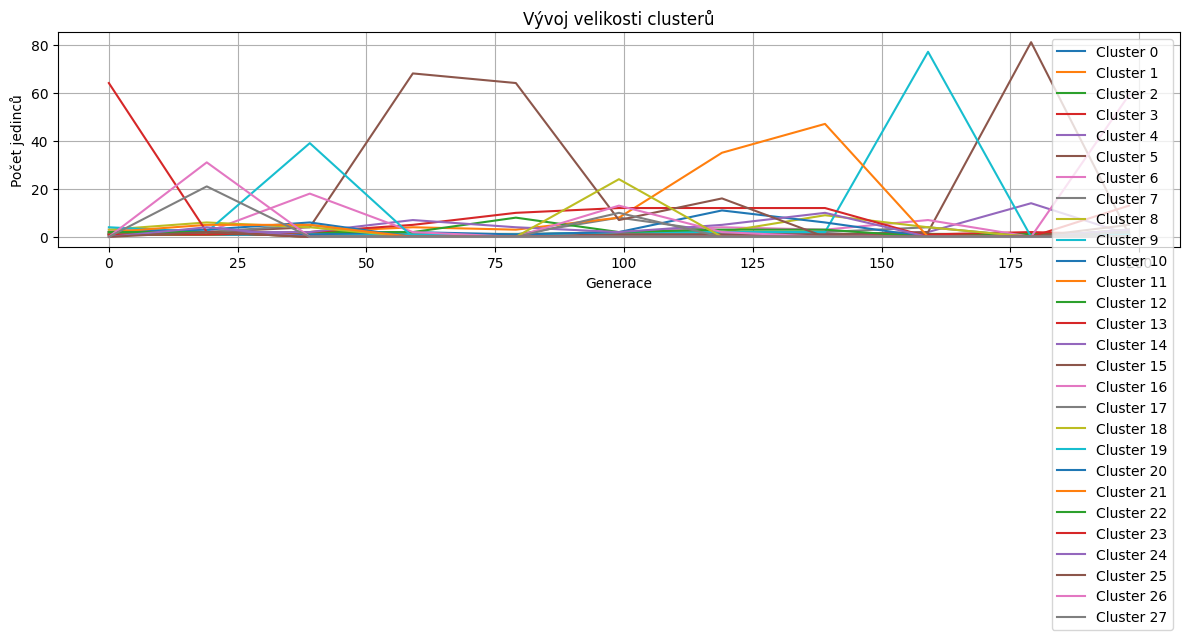

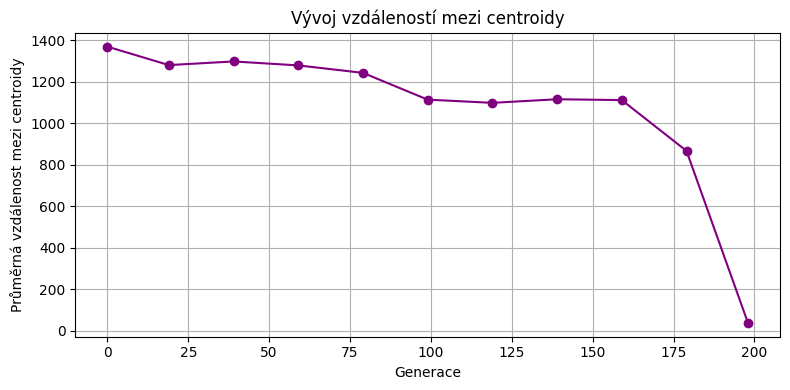


Posun centroidů mezi generací 0 a 19:
 - Cluster 0: 2057.0268
 - Cluster 1: 1553.9475
 - Cluster 2: 1659.7983
 - Cluster 3: 1613.1494
 - Cluster 4: 1640.6867
 - Cluster 5: 2017.0394
 - Cluster 6: 1210.5862
 - Cluster 7: 1041.9647
 - Cluster 8: 1387.0833
 - Cluster 9: 1709.7019
 - Cluster 10: 1740.2972
 - Cluster 11: 1071.8666
 - Cluster 12: 1577.6073
 - Cluster 13: 1452.0970
 - Cluster 14: 1862.7018
 - Cluster 15: 1302.5798
 - Cluster 16: 934.3261
 - Cluster 17: 1260.9015
 - Cluster 18: 1113.3933
 - Cluster 19: 1216.8885
 - Cluster 20: 1143.5237
 - Cluster 21: 518.6907
 - Cluster 22: 1428.8153
 - Cluster 23: 1015.0527

Posun centroidů mezi generací 19 a 39:
 - Cluster 0: 1486.2180
 - Cluster 1: 1125.0370
 - Cluster 2: 1119.4444
 - Cluster 3: 1634.1829
 - Cluster 4: 1387.2651
 - Cluster 5: 1559.1728
 - Cluster 6: 1710.7270
 - Cluster 7: 1281.5063
 - Cluster 8: 0.0000
 - Cluster 9: 917.1166
 - Cluster 10: 1391.3796
 - Cluster 11: 1279.3539
 - Cluster 12: 1409.4317
 - Cluster 13: 1505.94

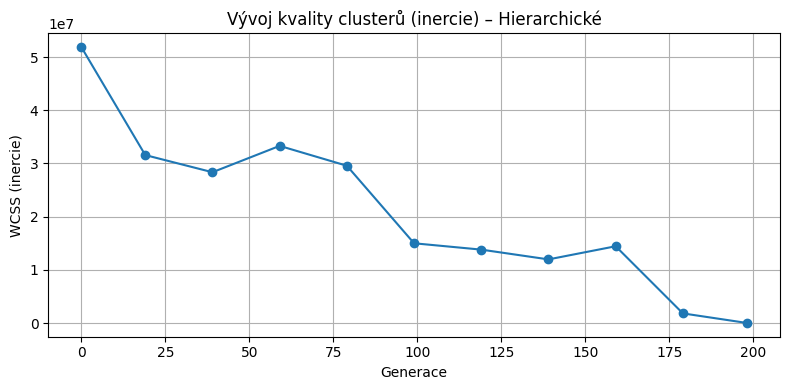

In [9]:
run("population_log_DE.csv", 3, 20)

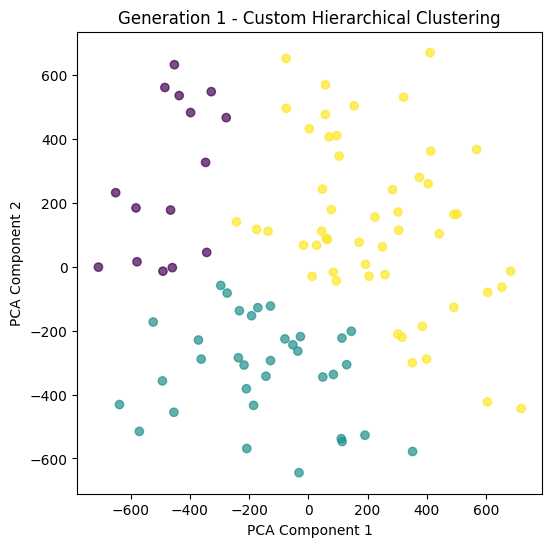

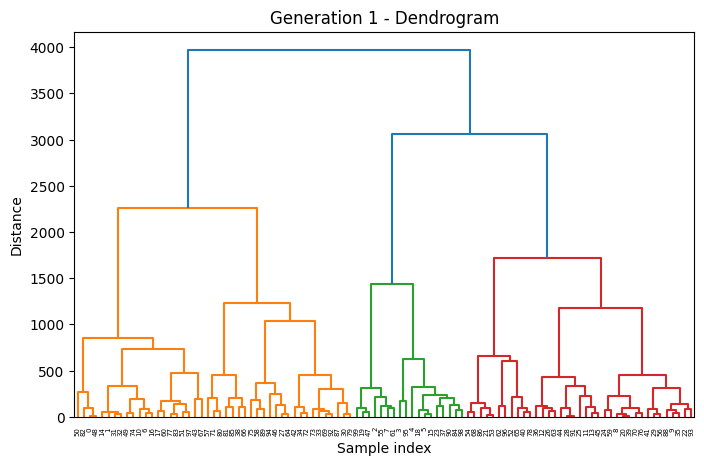

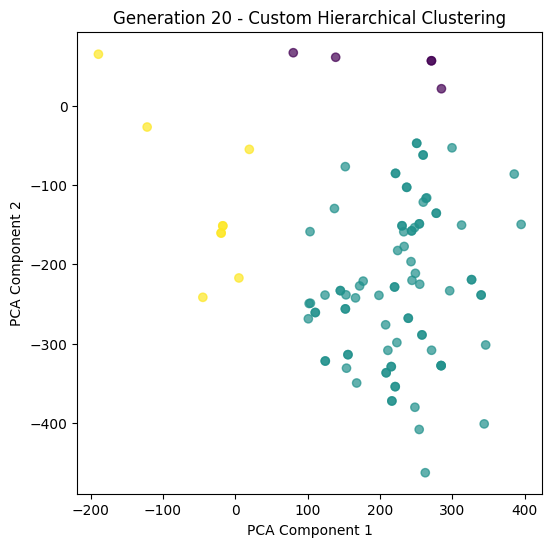

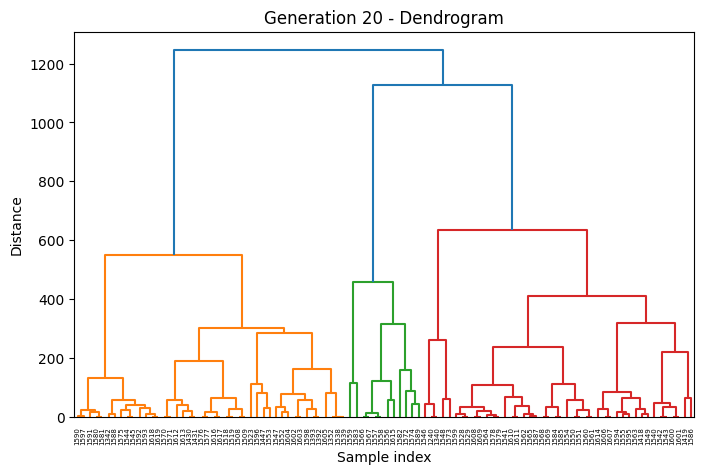

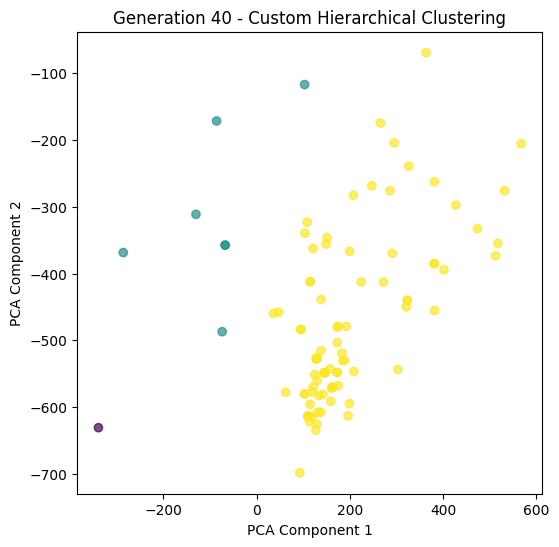

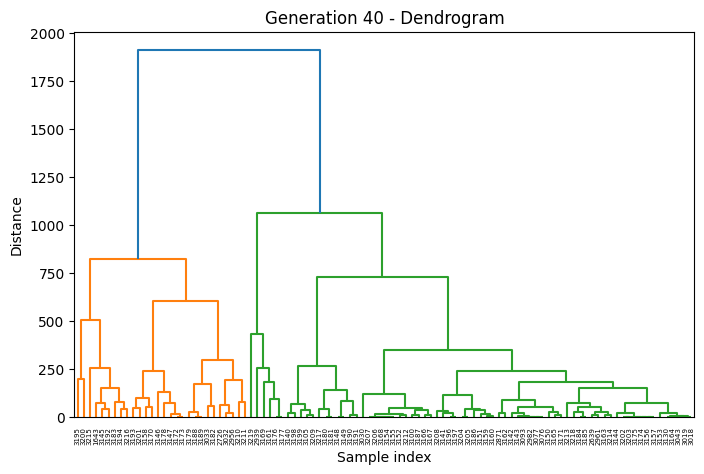

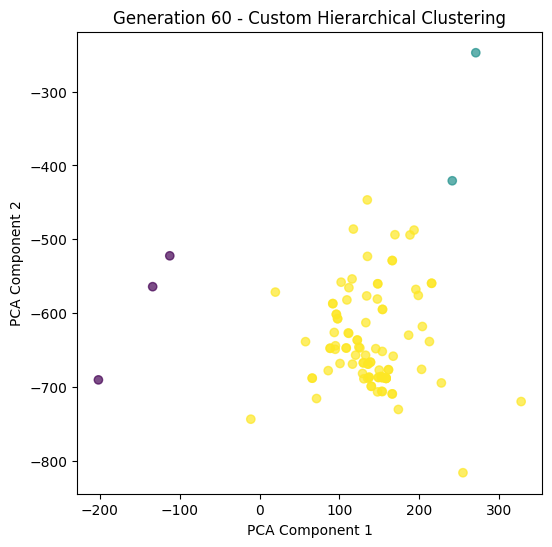

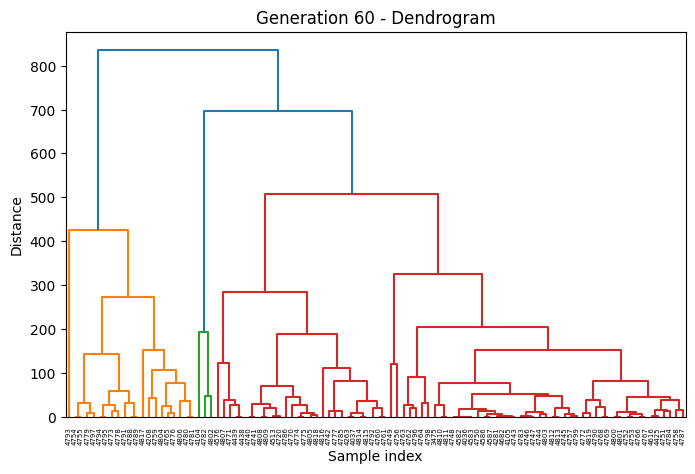

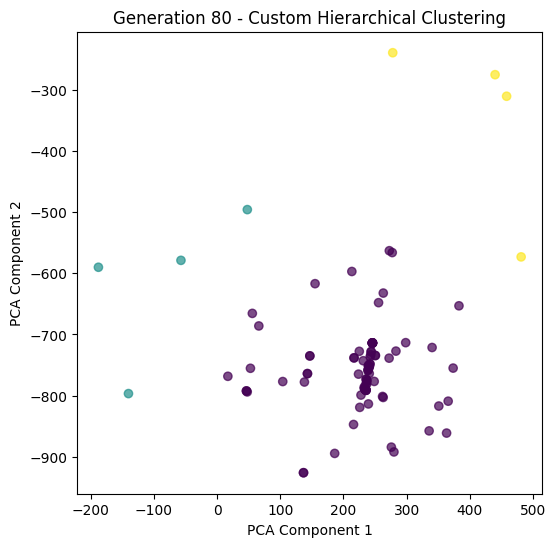

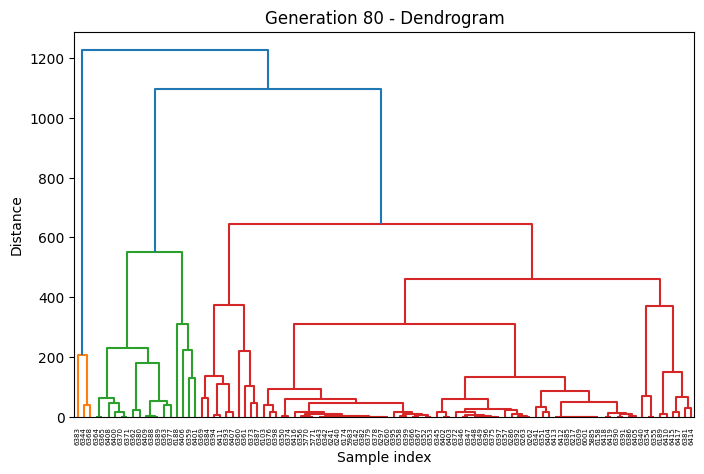

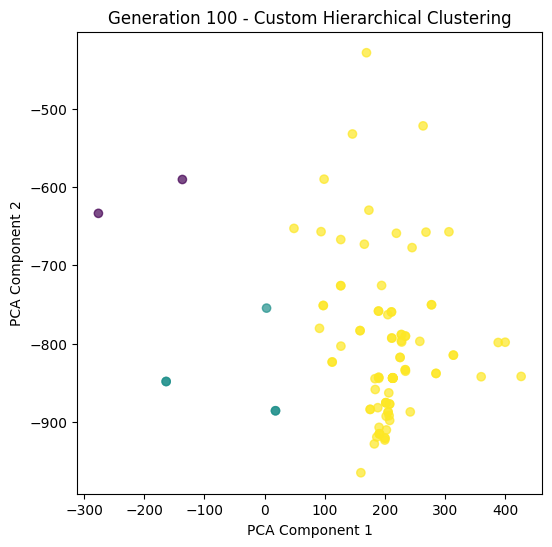

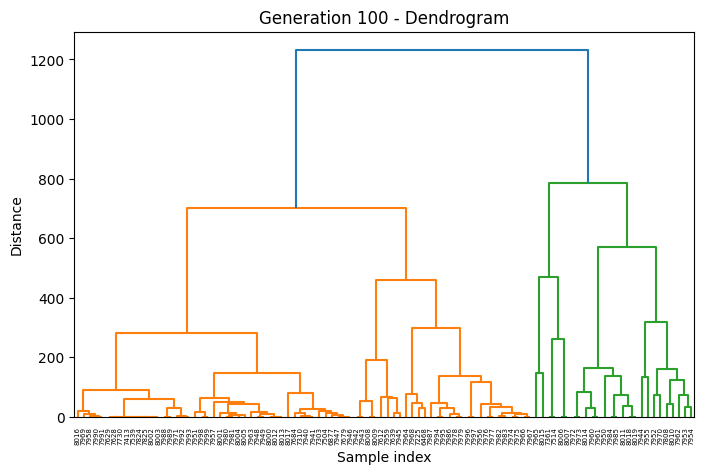

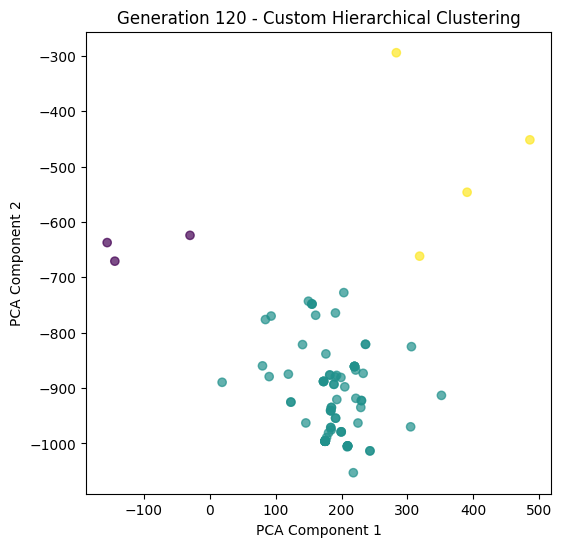

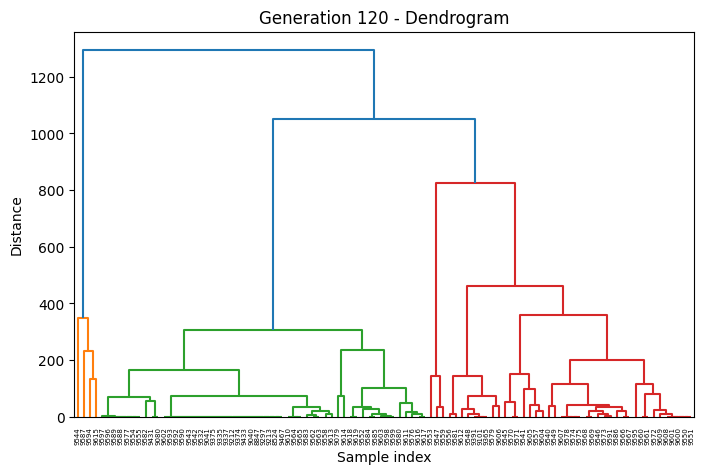

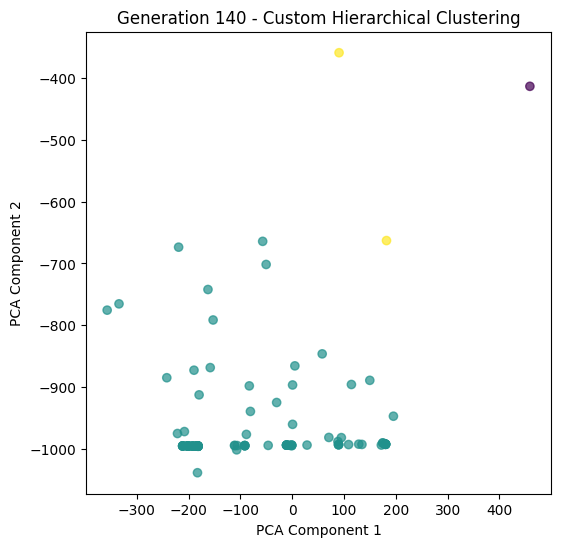

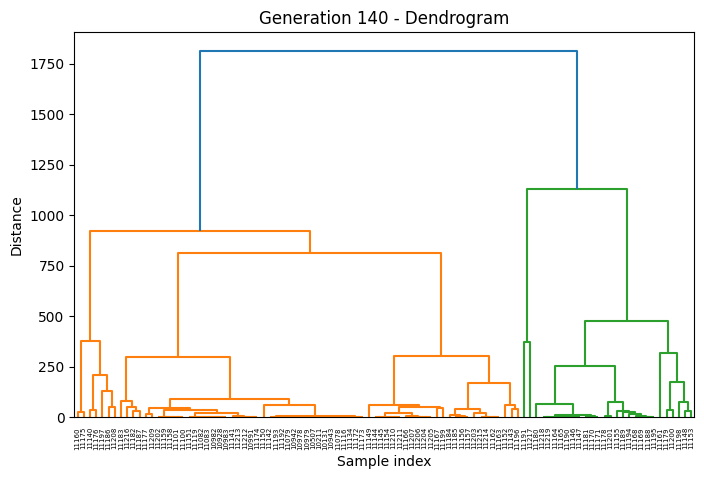

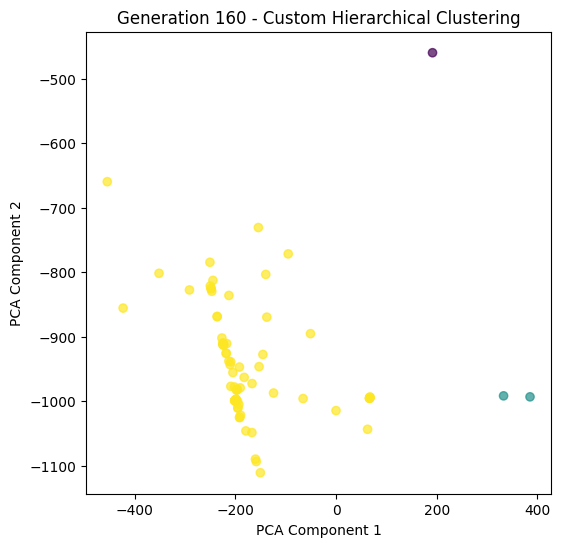

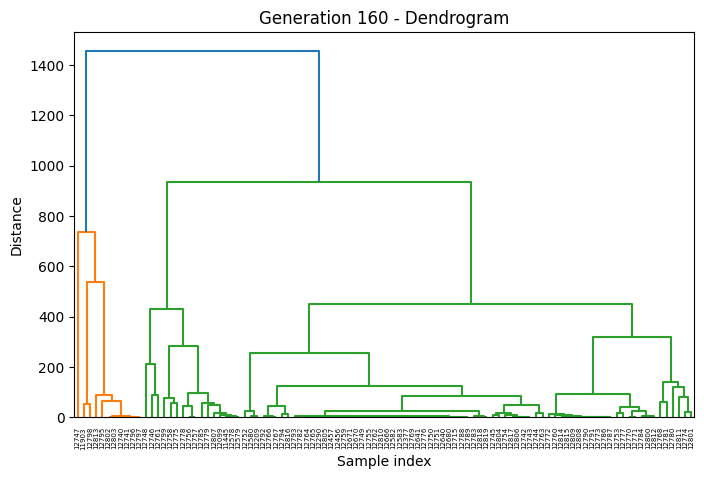

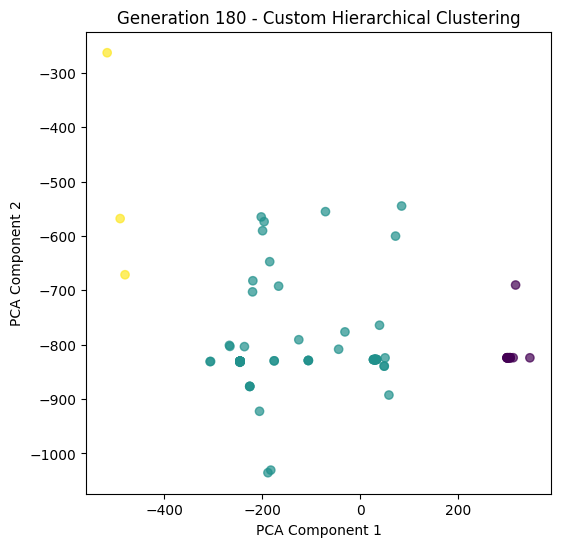

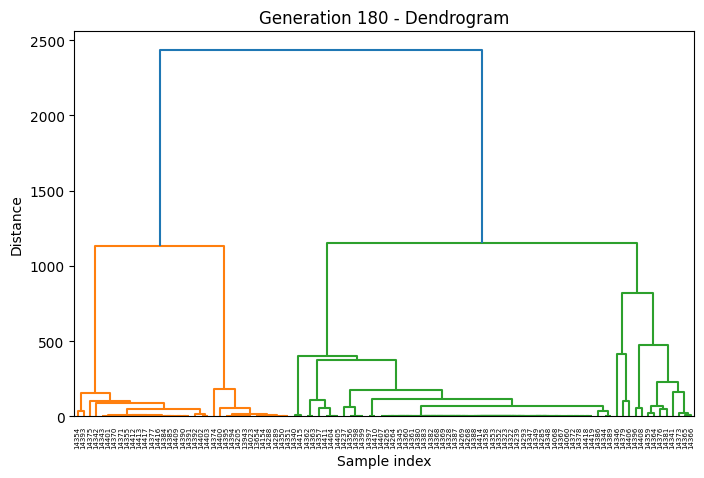

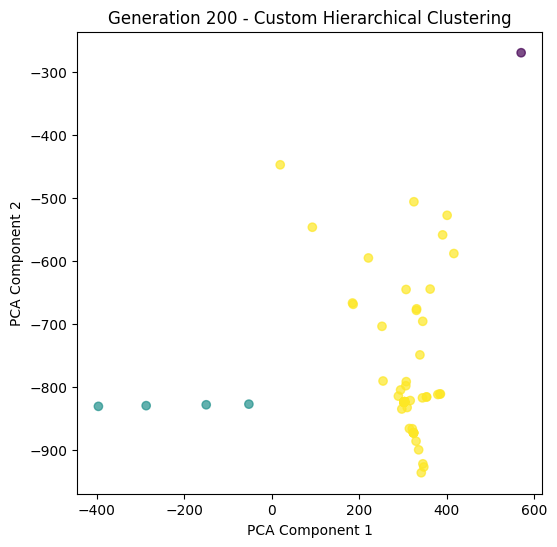

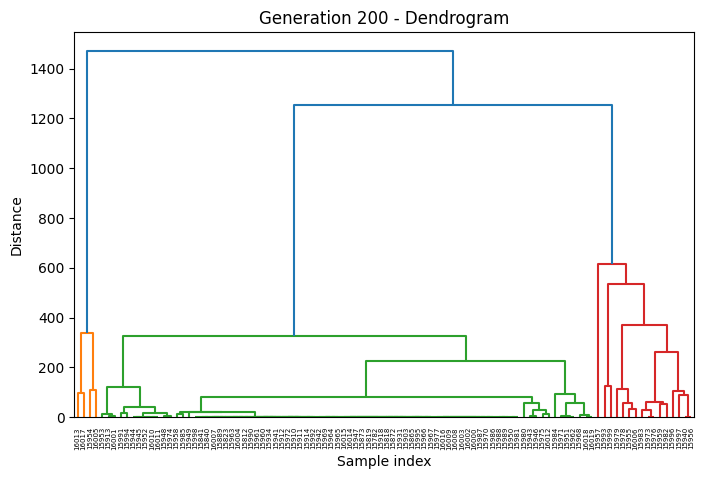

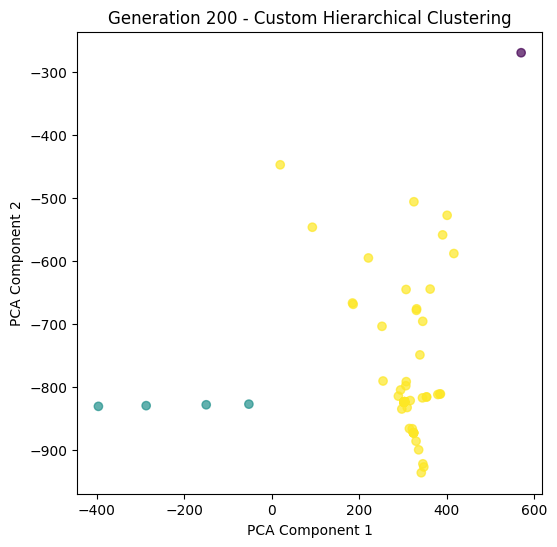

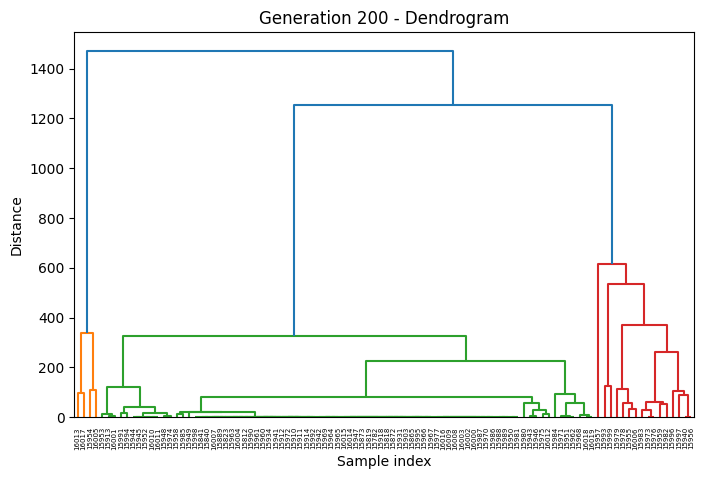

In [3]:
run("population_log_GA.csv", 3, 20)